# Setup the reconstruction

In [1]:
import rtoml
import os
import fnmatch
import sys

# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
recon_method = cfg['recon_type']

sys.path.append(f'src/')

data_dir_path = os.path.join(DATA_ROOT, DATA_DIR, 'raw/h5_proc')
if raw_file.isnumeric():
    raw_file_ = fnmatch.filter(os.listdir(data_dir_path), f'meas_MID*{raw_file}*.h5')[0]
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file_)
elif raw_file.startswith('meas_MID'):
    raw_file_ = raw_file
    ismrmrd_data_fullpath = os.path.join(data_dir_path, raw_file)
else:
    print('Could not find the file. Exiting...')
    exit(-1)

# Mapping from recon method to config file name for the server
recon_config = {'viewsharing': 'simplenufft1arm',
                'ttv': 'rtspiral_bart_tvrecon',
                'xdgrasp': 'spiral_xdgrasp_recon'}

# Run reconstruction
Algorithms/reconstructions are run as modules by the server component, which implements the [MRD streaming protocol](https://ismrmrd.readthedocs.io/en/latest/mrd_streaming_protocol.html).  The server must be started separately and a client sends data to the server for processing.  The server can be started via command line by running `python main.py`.

If using Visual Studio Code, [launch.json](../.vscode/launch.json) includes a debug configuration to run the server and allow for interactive debugging.  Click on the "Run and Debug" tab on the top left, then click the green play button to start the desired config ("Start server"):

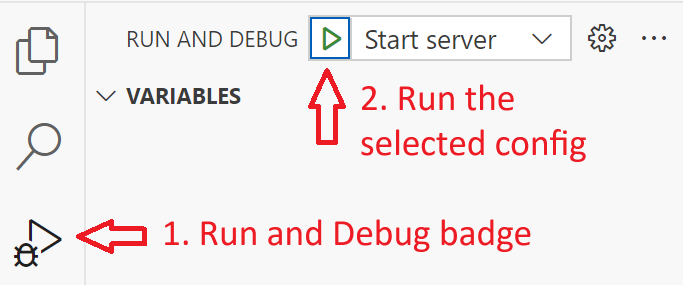

After the server is started, begin the reconstruction by running [client.py](../client.py) on the input dataset.  The recon code/module is selected by using the `config` argument.  The output is stored in a separate MRD file under a dataset named with the current date/time.

In [3]:
# Run reconstruction
from reconstruction import client
from types import SimpleNamespace
import datetime
from pathlib import Path

Path(f'output_recons/{DATA_DIR}').mkdir(exist_ok=True, parents=True)
outfilename = f'output_recons/{DATA_DIR}/{recon_method}_{raw_file_[:-3]}.mrd'

# Specify client arguments for recon
args = SimpleNamespace(**client.defaults)
args.out_group = f"{recon_method}_{str(datetime.datetime.now())}"
args.config   = recon_config[recon_method]  # Recon module to be used
args.outfile  = outfilename
args.filename = ismrmrd_data_fullpath
args.port = 9028
args.send_waveforms = True

client.main(args)

  dataset


ERROR:root:... Aborting


# Display the reconstructed images

File output_recons/vol0902_20240611/ttv_meas_MID00175_FID15580_pulseq2D_fire_spiralga_400mV_24MHz_editer.mrd contains 4 groups (reconstruction runs):
  ttv_2024-08-03 12:54:05.746588
  ttv_2024-08-03 12:58:21.784022
  ttv_2024-08-03 13:03:34.249169
  ttv_2024-08-03 13:08:10.248439
Group ttv_2024-08-03 13:08:10.248439 contains 1 image series:
  image_0


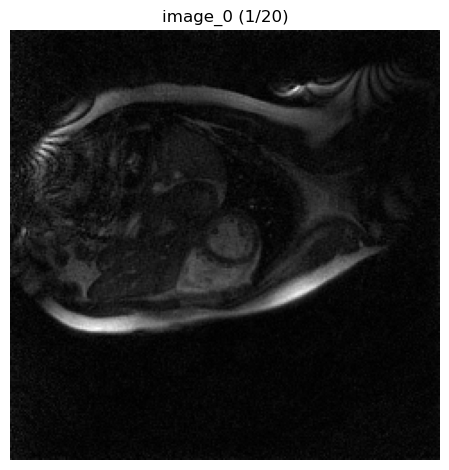

In [8]:
# Display the reconstructed images
import h5py
import ismrmrd
import matplotlib.pyplot as plt
import numpy as np

# If run multiple times, the recon.mrd file will have multiple reconstructed images
# Find the most recent recon run
with h5py.File(outfilename, 'r') as d:
    dsetNames = d.keys()
    print('File %s contains %d groups (reconstruction runs):' % (outfilename, len(dsetNames)))
    print(' ', '\n  '.join(dsetNames))
    group = list(dsetNames)[-1]

dset = ismrmrd.Dataset(outfilename, group, False)
subgroups = dset.list()

# Images are organized by series number in subgroups that start with 'images_'
imgGroups = [group for group in list(subgroups) if (group.find('image_') != -1)]
print('Group %s contains %d image series:' % (group, len(imgGroups)))
print(' ', '\n  '.join(imgGroups))

# Show images
fig, axs = plt.subplots(1, len(imgGroups), squeeze=False)

for i, series in enumerate(imgGroups):
    n = dset.number_of_images(series)
    img = dset.read_image(series, 4)
    axs[0][i].imshow(np.squeeze(img.data), cmap='gray')
    axs[0][i].set_title(series + ' (1/' + str(n) + ')')
    axs[0][i].axis('off')
    axs[0][i].set_aspect('equal')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()
dset.close()